 ## Run scripts

In [1]:
%run "Lab1_load_files.py"
%run "Lab1_load_files_weather.py"
%run "Lab1_load_passages.py"

for pollution_name in range(0,36):
    filepath_pollution_files=pollution_folder+"\\"+list_of_pollution_files[pollution_name]
    df=pd.read_csv(filepath_pollution_files)
    print(list_of_pollution_files[pollution_name],df.iloc[:,0].unique())

In [2]:
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, Polygon
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.dates as mdates

### load the three datasets

In [3]:
pollution_df=get_pollution_dataset()
passages_df=get_passages_data()
weather_df=get_weather_data()

In [4]:
pollution_df.loc[(pollution_df['Sensor_type']=='PM10 (SM2005)') & (pollution_df['DateObs']=='2013/11/01'),:]

,ID_sensor,DateObs,Pollution,Address,Pos_x,Pos_y,Sensor_type,Unit_measurement,geometry
0,10273,2013/11/01,46.0,Milano -via Carlo Pascal,45.478452,9.235016,PM10 (SM2005),µg/m,POINT (9.235016 45.478452)
5855,10320,2013/11/01,43.0,Milano - via Senato,45.470780,9.197180,PM10 (SM2005),µg/m,POINT (9.197179999999999 45.47078)
41234,6956,2013/11/01,41.0,Milano - via Verziere,45.463171,9.195995,PM10 (SM2005),µg/m,POINT (9.195995 45.463171)


## Write down the dataset

url='D:\\smarcitiesdata\\aggregated_pollution.csv'
pollution_df.to_csv(url)

url='D:\\smarcitiesdata\\aggregated_traffic.csv'
passages_df.to_csv(url)

url='D:\\smarcitiesdata\\aggregated_weather.csv'
weather_df.to_csv(url)

## check duplicates

In [5]:
len(pollution_df['ID_sensor'].unique())

36

In [6]:
pollution_df['DateObs']=pd.to_datetime(pollution_df['DateObs'])
pollution_df.loc[pollution_df['ID_sensor']==5551,]
list_of_sensor=pollution_df['ID_sensor'].unique()
for sensor in list_of_sensor:
    controllo_errori=pollution_df.loc[pollution_df['ID_sensor']==sensor,]['DateObs']
    print(len(controllo_errori.unique())==len(controllo_errori)) 
    if (len(controllo_errori.unique())==len(controllo_errori))==False:
        print(sensor)

True
True
True
True
True
True
True
True
True
False
17127
True
True
True
True
True
True
True
True
False
5551
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# drop duplicates

In [16]:
pollution_df.loc[pollution_df['Sensor_type']=='Ozono','Sensor_type']='Ozone'

In [17]:
pollution_no_duplicate=pollution_df.drop_duplicates(keep='first',subset=(pollution_df.columns[0:8]))

# create a flag for hourly and weekly sensors

In [18]:
occurrences=pd.DataFrame(pollution_no_duplicate.groupby(['ID_sensor','Sensor_type'],as_index=False)['DateObs'].count())
list_of_daily_sensor=list(occurrences.loc[occurrences['DateObs']<70,]['ID_sensor'])
list_of_hourly_sensor=list(occurrences.loc[occurrences['DateObs']>70,]['ID_sensor'])

In [19]:
len(list_of_hourly_sensor)

31

# split the dataframes

In [20]:
db_hourly=pollution_no_duplicate.loc[pollution_no_duplicate['ID_sensor'].isin(list_of_hourly_sensor)]
db_daily=pollution_no_duplicate.loc[pollution_no_duplicate['ID_sensor'].isin(list_of_daily_sensor)]

## create variable of hours and days

In [21]:
dt = datetime.datetime.fromtimestamp(db_hourly['DateObs'].min().timestamp())
end =datetime.datetime.fromtimestamp (db_hourly['DateObs'].max().timestamp())

step = datetime.timedelta(hours=1)

result=[]

while dt < end:
    result.append(dt)
    dt += step
result_timestamps=pd.to_datetime(result)

In [22]:
dt = datetime.datetime.fromtimestamp(db_daily['DateObs'].min().timestamp())
end =datetime.datetime.fromtimestamp (db_daily['DateObs'].max().timestamp())

step = datetime.timedelta(days=1)

result=[]

while dt < end:
    result.append(dt)
    dt += step
result_timestamps_daily=pd.to_datetime(result)

In [23]:
print(db_hourly.shape[0]+db_daily.shape[0])
print(pollution_no_duplicate.shape[0])

39803
39803


## Missing values in the pollution database by sensor

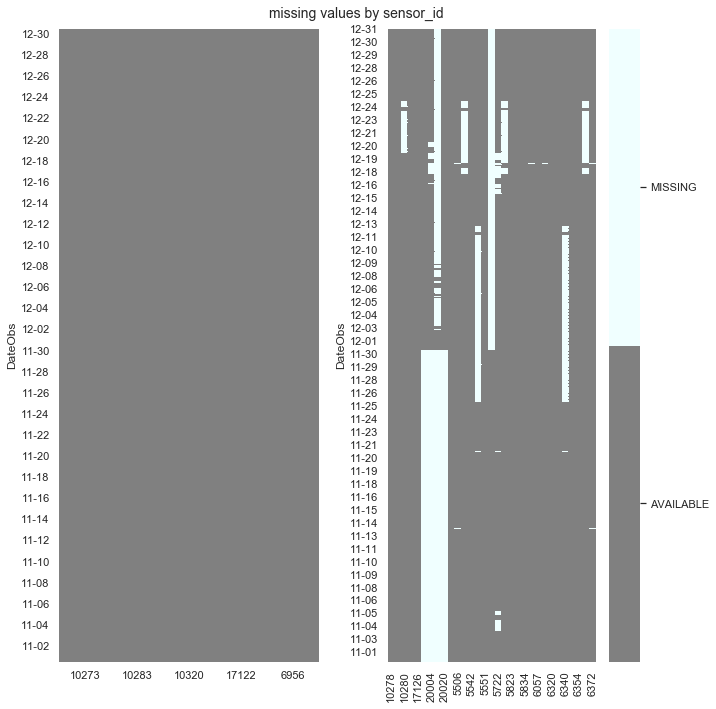

In [24]:
fig,axs=plt.subplots(ncols=2,figsize=(10,10))
cmap_colour=['grey','azure']

left_db=pd.DataFrame(result_timestamps_daily,columns=['DateObs'])

### create the list of sensor
list_of_sensor=db_daily['ID_sensor'].unique()

for sensor_id in list_of_sensor:
    right_db=db_daily.loc[db_daily['ID_sensor']==sensor_id,['ID_sensor','DateObs']]
    right_db.rename(columns={'ID_sensor':sensor_id},inplace=True)
    left_db=pd.merge(left_db,right_db,how='left')
    
left_db.set_index(left_db['DateObs'].dt.strftime('%m-%d'),inplace=True)
left_db.sort_index(ascending=False,inplace=True)
sns.heatmap(left_db.iloc[:,1:].isnull(), cbar=False,ax=axs[0],cmap=cmap_colour);



###
left_db=pd.DataFrame(result_timestamps,columns=['DateObs'])
### create the list of sensor
list_of_sensor=db_hourly['ID_sensor'].unique()

for sensor_id in list_of_sensor:
    right_db=db_hourly.loc[db_hourly['ID_sensor']==sensor_id,['ID_sensor','DateObs']]
    right_db.rename(columns={'ID_sensor':sensor_id},inplace=True)
    left_db=pd.merge(left_db,right_db,how='left')
    
left_db.set_index(left_db['DateObs'].dt.strftime('%m-%d'),inplace=True)
left_db.sort_index(ascending=False,inplace=True)

ax=sns.heatmap(left_db.iloc[:,1:].isnull(), cbar=True,ax=axs[1],cmap=cmap_colour);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['AVAILABLE', 'MISSING'])

plt.suptitle('missing values by sensor_id',fontsize=14);

plt.tight_layout()
plt.subplots_adjust(top=0.95)

create a flag for the hourly variables

 ### Missing value for pollution database by type of sensors
 

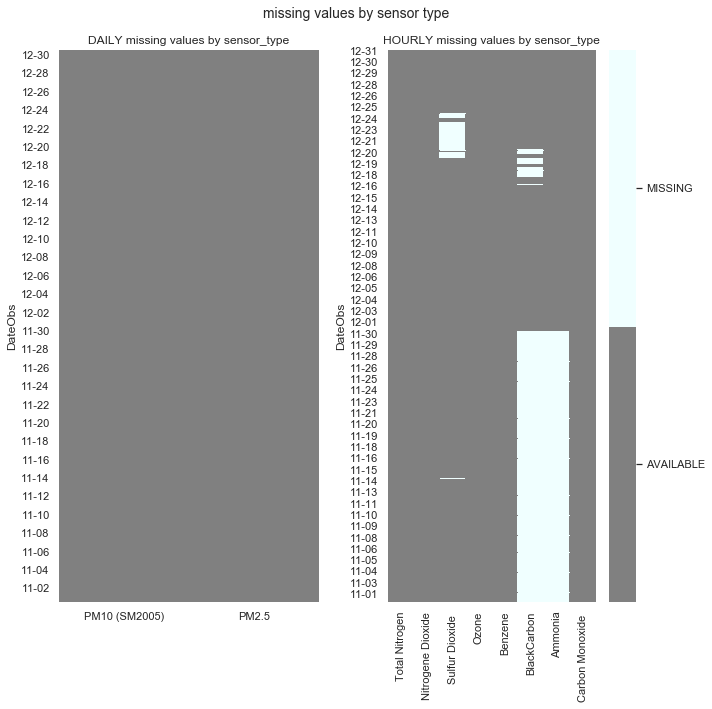

In [25]:
fig,axs=plt.subplots(ncols=2,figsize=(10,10))
cmap_colour=['grey','azure']
left_db=pd.DataFrame(result_timestamps_daily,columns=['DateObs'])

### create the list of sensor
list_of_sensor_type=db_daily['Sensor_type'].unique()
### SAME FOR POLLUTANT

for sensor_id in list_of_sensor_type:
    right_db=db_daily.loc[db_daily['Sensor_type']==sensor_id,['Sensor_type','DateObs']]
    right_db.rename(columns={'Sensor_type':sensor_id},inplace=True)
    right_db.drop_duplicates(inplace=True)
    left_db=pd.merge(left_db,right_db,how='left')

    
left_db.set_index(left_db['DateObs'].dt.strftime('%m-%d'),inplace=True)    
left_db.sort_index(ascending=False,inplace=True)
sns.heatmap(left_db.iloc[:,1:].isnull(), cbar=False,ax=axs[0],cmap=cmap_colour);
axs[0].set_title('DAILY missing values by sensor_type');
#plt.xlab('Sensor_id')



left_db=pd.DataFrame(result_timestamps,columns=['DateObs'])

### create the list of sensor
list_of_sensor_type=db_hourly['Sensor_type'].unique()
### SAME FOR POLLUTANT

for sensor_id in list_of_sensor_type:
    right_db=db_hourly.loc[db_hourly['Sensor_type']==sensor_id,['Sensor_type','DateObs']]
    right_db.rename(columns={'Sensor_type':sensor_id},inplace=True)
    right_db.drop_duplicates(inplace=True)
    left_db=pd.merge(left_db,right_db,how='left')

    
left_db.set_index(left_db['DateObs'].dt.strftime('%m-%d'),inplace=True)
left_db.sort_index(ascending=False,inplace=True)

ax=sns.heatmap(left_db.iloc[:,1:].isnull(), cbar=True,ax=axs[1],cmap=cmap_colour);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['AVAILABLE', 'MISSING'])

axs[1].set_title('HOURLY missing values by sensor_type');

plt.suptitle('missing values by sensor type',fontsize=14);

plt.tight_layout()
plt.subplots_adjust(top=0.92)

check this one

https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

# RESAMPLING

prima rendo il giornaliero orario

In [26]:
db_hourly=pollution_no_duplicate.loc[pollution_no_duplicate['ID_sensor'].isin(list_of_hourly_sensor)]
db_daily=pollution_no_duplicate.loc[pollution_no_duplicate['ID_sensor'].isin(list_of_daily_sensor)]

## Resampling  

### Here I resampled the daily pollution database, from daily to hourly

In [27]:
def resampling_from_daily_to_hourly(database_daily):
    lista_sensori=database_daily['ID_sensor'].unique()
    index=database_daily['DateObs']
    database_daily.set_index(index,inplace=True)
    db_resampled=pd.DataFrame()
    for sensor in lista_sensori:
        a=database_daily.loc[database_daily['ID_sensor']==sensor,:]
        db_resampled=db_resampled.append(a.resample('H').pad())
    return db_resampled

PLEASE NOTE THAT THIS AUTOMATICALLY TAKES THE MEAN AMONG ALL SAME TYPE OF SENSORS...

this is to control for "ozone" and "ozono"

In [29]:
db_daily_resampled=resampling_from_daily_to_hourly(db_daily)
db_daily_resampled['ID_sensor'].unique()

for idsensor in db_daily_resampled['ID_sensor'].unique():
    print(db_daily_resampled.loc[(db_daily_resampled['ID_sensor']==idsensor) & (db_daily_resampled['DateObs']=='2013-11-01'),:].shape[0])

24
24
24
24
24


In [30]:
db_daily_resampled=resampling_from_daily_to_hourly(db_daily)
db_daily_resampled['tempo']=db_daily_resampled.index.copy()
db_daily_new=db_daily_resampled.pivot_table(index='tempo',columns='Sensor_type',values='Pollution') 


db_hourly=db_hourly.copy()
db_hourly.loc[:,'tempo']=db_hourly.loc[:,'DateObs']
db_hourly_new=db_hourly.pivot_table(index='tempo',columns='Sensor_type',values='Pollution') 

## ecco i due database del pollution  (ancora da fare l 'imputazione)

db_daily_new  
db_hourly_new

## this is the vehicles database
(this can be made by using resample, and "sum")

In [31]:
passages_df['passages']=1
## create occurrencies
timeindex=pd.to_datetime(passages_df['Timestamp'])
passages_df.set_index(timeindex,inplace=True)

passages_resampled=passages_df.groupby([pd.Grouper(freq='60Min'),' EURO',' VType',' FType',' DPF'],as_index=True)[' Length','passages'].sum()
passages_resampled.reset_index(level=[' EURO', ' VType',' FType',' DPF'],inplace=True)

passages_resampled['tempo']=passages_resampled.index
passages_resampled['codice']=passages_resampled[[' EURO', ' VType', ' FType', ' DPF']].apply(lambda x: ''.join(x.astype('str')), axis=1)

passages_new=passages_resampled.loc[:,['codice','passages','tempo']].pivot(columns='codice',values='passages',index='tempo')
passages_new.fillna(0,inplace=True)
passages_lenght_new=passages_resampled.loc[:,['codice',' Lenght','tempo']].pivot(columns='codice',values=' Lenght',index='tempo')

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


we decide to make also a more fit database for passages...where we have only 5 groups:

- "VEHICLES_NA" the not available
- "CARS_FUEL_NO_CLEAN" Vtype==4 and EURO >=1 <=4" the fuel car EURO 0-EURO 5
- "CARS_FUEL_CLEAN" Vtype==4 and EURO >=5 " the fuel car over EURO 4
- "CARS_GREEN"  Vtype==4 and EURO >4 " non-fuel car (electric, hybrid...etc...)
- "VEHICLES_OTHER_NO_CLEAN" "Vtype!= 0 and 4 and less than EURO 3"  
- "VEHICLES_OTHER_CLEAN" "Vtype!= 0 and 4 and more than EURO 3"
- "VEHICLES_OTHER_GREEN" "Vtype!= 0 and non-diesel/fuel" (electric.hybrid etc...)
- "VEHICLES_OTHER_NOTNA" vehicles for which we have some information but do not enter in any of the above groups

type_of_vehicle
CARS_FUEL_CLEAN            2475012
CARS_FUEL_NO_CLEAN         3594545
CARS_GREEN                  954003
VEHICLES_NA                1326313
VEHICLES_OTHER_CLEAN        664469
VEHICLES_OTHER_GREEN        135672
VEHICLES_OTHER_NOTNA          6125
VEHICLES_OTHER_NO_CLEAN      27336
Name: passages, dtype: int64


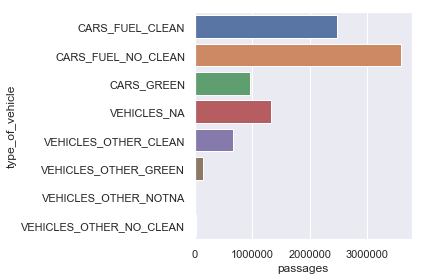

In [32]:
passages_df['type_of_vehicle']='NaN'
passages_df.loc[(passages_df[' VType']==4) & (passages_df[' EURO']>=1) & (passages_df[' EURO']<=5)  ,'type_of_vehicle']='CARS_FUEL_NO_CLEAN'
passages_df.loc[(passages_df[' VType']==4) & (passages_df[' EURO']>5),'type_of_vehicle']='CARS_FUEL_CLEAN'
passages_df.loc[(passages_df[' VType']==4) & (passages_df[' FType']!=0) & (passages_df[' FType']!=1) & (passages_df[' FType']!=2),'type_of_vehicle']='CARS_GREEN'
passages_df.loc[(passages_df[' VType']!=4) & (passages_df[' VType']!=0) & (passages_df[' EURO']>=1) & (passages_df[' EURO']<=3) ,'type_of_vehicle']='VEHICLES_OTHER_NO_CLEAN'
passages_df.loc[(passages_df[' VType']!=4) & (passages_df[' VType']!=0) & (passages_df[' EURO']>3) ,'type_of_vehicle']='VEHICLES_OTHER_CLEAN'
passages_df.loc[(passages_df[' VType']!=4) & (passages_df[' VType']!=0) & (passages_df[' FType']!=1) & (passages_df[' FType']!=2) ,'type_of_vehicle']='VEHICLES_OTHER_GREEN'
passages_df.loc[passages_df['type_of_vehicle']=='NaN','type_of_vehicle']='VEHICLES_NA'
passages_df.loc[(passages_df['type_of_vehicle']=='VEHICLES_NA') & ((passages_df[' Length']!=0) | (passages_df[' VType']!=0) | (passages_df[' FType']!=0) | (passages_df[' EURO']!=0)),'type_of_vehicle']='VEHICLES_OTHER_NOTNA'

### resample
passages_resampled=passages_df.groupby([pd.Grouper(freq='60Min'),'type_of_vehicle'],as_index=True)['passages'].sum()
passages_resampled=pd.DataFrame(passages_resampled)
passages_resampled.reset_index(level=['type_of_vehicle'],inplace=True)
passages_resampled['tempo']=passages_resampled.index
passages_new_type_of_vehicle=passages_resampled.loc[:,['type_of_vehicle','passages','tempo']].pivot(columns='type_of_vehicle',values='passages',index='tempo')
passages_new_type_of_vehicle.fillna(0,inplace=True)


print(passages_df.groupby('type_of_vehicle')['passages'].count())
sns.barplot(y=passages_df.groupby('type_of_vehicle')['passages'].count().index,x=passages_df.groupby('type_of_vehicle')['passages'].count())
plt.tight_layout()


## Questo il resampled del traffico

passages_new (non serve imputarlo)

# quello con less variables 

passages_new_type_of_vehicle

this is to make sure we have only one ID for each sensor type

In [33]:
db_hourly.loc[:,['ID_sensor','Sensor_type']].groupby('ID_sensor').nunique()

,ID_sensor,Sensor_type
ID_sensor,,
5504,1,1
5506,1,1
5531,1,1
5542,1,1
5550,1,1
5551,1,1
5552,1,1
5722,1,1
5725,1,1


## Weather database

prima controlliamo gli NA

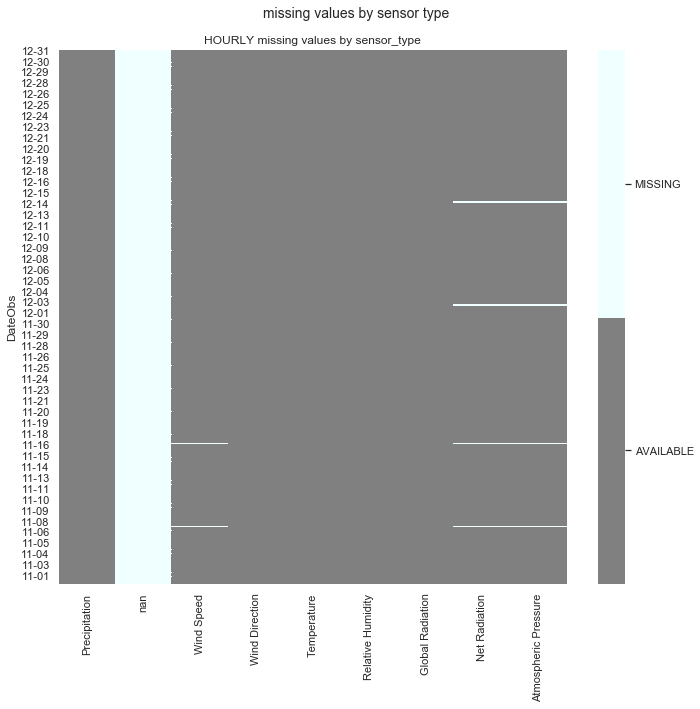

In [34]:
fig,axs=plt.subplots(ncols=1,figsize=(10,10))

left_db=pd.DataFrame(result_timestamps,columns=['DateObs'])

### create the list of sensor
list_of_sensor_type=weather_df['Sensor_type'].unique()
### SAME FOR POLLUTANT

for sensor_id in list_of_sensor_type:
    right_db=weather_df.loc[weather_df['Sensor_type']==sensor_id,['Sensor_type','DateObs']]
    right_db.rename(columns={'Sensor_type':sensor_id},inplace=True)
    right_db['DateObs']=pd.to_datetime(right_db['DateObs'])
    right_db.drop_duplicates(inplace=True)
    left_db=pd.merge(left_db,right_db,on='DateObs',how='left')

    
left_db.set_index(left_db['DateObs'].dt.strftime('%m-%d'),inplace=True)
left_db.sort_index(ascending=False,inplace=True)

ax=sns.heatmap(left_db.iloc[:,1:].isnull(), cbar=True,cmap=cmap_colour);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['AVAILABLE', 'MISSING'])

ax.set_title('HOURLY missing values by sensor_type');

plt.suptitle('missing values by sensor type',fontsize=14);

plt.tight_layout()
plt.subplots_adjust(top=0.92)

questo è il weather resampled

In [35]:
## create occurrencies

weather_df_notnull=weather_df.loc[weather_df['Sensor_type'].notnull(),:].copy()

timeindex=pd.to_datetime(weather_df_notnull['DateObs'])

weather_df_notnull.set_index(timeindex,inplace=True)

weather_df_notnull.loc[:,'Weather_Indicator']=pd.to_numeric(weather_df_notnull['Weather_Indicator']).to_numpy()
weather_resampled=pd.DataFrame(weather_df_notnull.groupby([pd.Grouper(freq='60min'),'Sensor_type'],as_index=True)['Weather_Indicator'].mean())

weather_resampled.reset_index(level=['Sensor_type'],inplace=True)

list_of_sensors=weather_resampled['Sensor_type'].unique()
weather_new=weather_resampled.pivot(columns='Sensor_type',values='Weather_Indicator')
weather_new.index.rename('tempo',inplace=True)
weather_new.index=pd.to_datetime(weather_new.index)

In [152]:
weather_df[weather_df['Sensor_type']=='Precipitation']

,ID_sensor,DateObs,Weather_Indicator,Address,Pos_x,Pos_y,Sensor_type,Unit_measurement,geometry
0,14121,2013/11/14 17:00,0.8,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
1,14121,2013/11/14 18:00,0.6,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
2,14121,2013/11/14 19:00,0.4,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
3,14121,2013/11/14 20:00,0.4,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
4,14121,2013/11/14 21:00,0,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
5,14121,2013/11/14 22:00,3.2,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
6,14121,2013/11/14 23:00,5.2,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
7,14121,2013/11/15 00:00,7.2,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
8,14121,2013/11/15 01:00,7,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)
9,14121,2013/11/15 02:00,5.4,Milano - via Ippolito Rosellini,45.490043,9.194632,Precipitation,mm,POINT (9.194632 45.490043)


the dataset of weather is:  
weather_resampled

# ECCO I TRE DATASET

In [498]:
## WEATHER
## wide to long
weather_new

,Atmospheric Pressure,Global Radiation,Net Radiation,Precipitation,Relative Humidity,Temperature,Wind Direction,Wind Speed
DateObs,,,,,,,,
2013-11-01 01:00:00,1007.3,0.0,-54.0,0.00,89.80,11.600000,306.666667,0.500000
2013-11-01 02:00:00,1006.9,0.0,-50.0,0.00,89.60,11.200000,197.333333,0.800000
2013-11-01 03:00:00,1006.6,0.0,-53.0,0.00,90.80,10.883333,217.666667,0.500000
2013-11-01 04:00:00,1006.3,0.0,-56.0,0.00,91.60,10.533333,231.000000,0.700000
2013-11-01 05:00:00,1006.1,0.0,-50.0,0.00,93.40,10.283333,84.666667,0.500000
2013-11-01 06:00:00,1006.1,0.0,-41.0,0.00,93.60,9.916667,236.000000,0.700000
2013-11-01 07:00:00,1006.1,0.0,-35.0,0.00,94.40,9.800000,48.000000,0.900000
2013-11-01 08:00:00,1006.6,32.0,-7.0,0.00,94.40,10.316667,63.000000,0.800000
2013-11-01 09:00:00,1007.0,157.0,51.0,0.00,89.80,11.850000,70.333333,1.000000


In [ ]:
### POLLUTION
db_daily_new  
db_hourly_new

In [126]:
## TRAFFIC
## many NAs...forse meglio groupare solo con Euro type..
passages_new
passages_lenght_new

### quello con i gruppi
passages_new_type_of_vehicle

### this is to check we have all of them
passages_resampled['passages'].sum()
passages_new.sum().sum()

### and those are the one that matters...we might decite to delete those with very low values.... (that are probably insignificant)
passages_new.sum()

codice
0000    1326329.0
0001       2055.0
0002       3292.0
0121          1.0
0122          8.0
0130         66.0
0230        296.0
0300          9.0
0322          3.0
0330       1106.0
0332         69.0
0421         10.0
0430       4661.0
0432         92.0
0442          1.0
1002        692.0
1112          1.0
1120         38.0
1121         32.0
1122        101.0
1212          1.0
1220         43.0
1221         36.0
1222        152.0
1302          2.0
1312         82.0
1320         63.0
1321          3.0
1322        834.0
1342        278.0
          ...    
6342      43726.0
6401          1.0
6410       2746.0
6411        288.0
6412     785472.0
6420        135.0
6421    1612742.0
6422       1759.0
6430          1.0
6432         27.0
6440       1142.0
6441        122.0
6442     184454.0
6450        604.0
6451       3043.0
6452     215480.0
7221          5.0
7222          8.0
7312        138.0
7321        850.0
7342         44.0
7410        174.0
7412      19545.0
7421      52087.0
742

In [40]:
path_weather="D:\smarcitiesdata\DatiAirQuality\Aggregated_Data\weather.csv"
path_pollution1="D:\smarcitiesdata\DatiAirQuality\Aggregated_Data\pollution1.csv"
path_pollution2="D:\smarcitiesdata\DatiAirQuality\Aggregated_Data\pollution2.csv"
path_passages1="D:\smarcitiesdata\DatiAirQuality\Aggregated_Data\passages1.csv"
path_passages2="D:\smarcitiesdata\DatiAirQuality\Aggregated_Data\passages2.csv"

In [41]:
weather_new.to_csv(path_weather)
db_daily_new.to_csv(path_pollution1)  
db_hourly_new.to_csv(path_pollution2)
passages_new.to_csv(path_passages1)
passages_new_type_of_vehicle.to_csv(path_passages2)

## Visualize where the sensors are located

In [80]:
weather_df.shape

(39167, 9)

In [9]:
%run "Lab1_load_files.py"
%run "Lab1_load_files_weather.py"
%run "Lab1_load_passages.py"
pollution_df=get_pollution_dataset()
passages_df=get_passages_data()
weather_df=get_weather_data()

In [74]:
pd.DataFrame(passages_df[['Sensor type','ID_sensor']].drop_duplicates().groupby('Sensor type')['ID_sensor'].count()).rename({'ID_sensor':'Number of sensors'},axis=1)

,Number of sensors
Sensor type,
Pedaggio,36
Tpl,6


In [65]:
pd.DataFrame(weather_df[['Sensor_type','ID_sensor']].drop_duplicates().groupby('Sensor_type')['ID_sensor'].count()).rename({'ID_sensor':'Number of sensors'},axis=1)

,Number of sensors
Sensor_type,
Atmospheric Pressure,1
Global Radiation,1
Net Radiation,1
Precipitation,4
Relative Humidity,5
Temperature,6
Wind Direction,6
Wind Speed,6


In [63]:
pd.DataFrame(pollution_df[['Sensor_type','ID_sensor']].drop_duplicates().groupby('Sensor_type')['ID_sensor'].count()).rename({'ID_sensor':'Number of sensors'},axis=1)

,Number of sensors
Sensor_type,
Ammonia,1
Benzene,4
BlackCarbon,2
Carbon Monoxide,4
Nitrogene Dioxide,8
Ozone,1
Ozono,2
PM10 (SM2005),3
PM2.5,2


In [50]:
pollution_df.groupby(['Sensor_type'],as_index=True)['ID_sensor'].count()

Sensor_type
Ammonia                743
Benzene               5868
BlackCarbon            780
Carbon Monoxide       5846
Nitrogene Dioxide    11142
Ozone                 1461
Ozono                 2665
PM10 (SM2005)          174
PM2.5                  120
Sulfur Dioxide        1352
Total Nitrogen       11137
Name: ID_sensor, dtype: int64

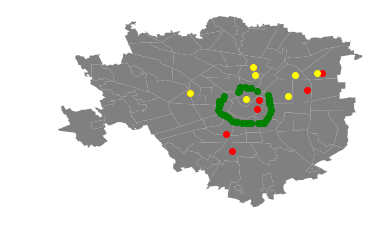

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt

def get_unique_points(db):
    db=db[['Pos_x','Pos_y']].drop_duplicates()
    geometries=gpd.GeoSeries([Point(yx) for yx in zip(db['Pos_y'],db['Pos_x'])])
    return geometries


quartieri_milano=gpd.read_file("cartine_geografiche_milano")
quartieri_milano['geometry']=quartieri_milano['geometry'].to_crs(epsg=4326)

fig,axs=plt.subplots(ncols=1)

quartieri_milano.plot(ax=axs,color='grey')

get_unique_points(pollution_df).plot(color='red',ax=axs)
get_unique_points(passages_df).plot(color='green',ax=axs)
get_unique_points(weather_df).plot(color='yellow',ax=axs);

axs.set_axis_off()
#fig.suptitle(' yellow=weather stations \n red=pollution \n green=passages');